In [3]:
import random
class AMM:
    def __init__(self):
        self.D = random.randint(10,1000)
        self.T = random.randint(10,1000)
        self.C = self.D * self.T

    def __repr__(self):
        return f"AMM ({self.D}, {self.T}) - C = {self.C}"


def arbitrage(amm1, amm2):
    Di, Ti, Ci = amm1.D, amm1.T, amm1.C
    Dj, Tj, Cj = amm2.D, amm2.T, amm2.C
    # print(f"original: ({Di}, {Ti}), ({Dj}, {Tj})")
    # note: the "rewritten" formula from the PDF wasn't working, so I used the non-simplified version of the formula
    dDi = ((Ci*Cj)**.5 - Di * Tj) / (Ti + Tj)
    dTi = Ci / (Di + dDi) - Ti
    dTj = -dTi
    dDj = Cj / (Tj + dTj) - Dj
    # print(f"change: ({dDi}, {dTi}), ({dDj}, {dTj})")
    amm1.D, amm1.T, amm2.D, amm2.T = Di+dDi, Ti+dTi, Dj+dDj, Tj+dTj
    # print(f"new: ({amm1.D}, {amm1.T}), ({amm2.D}, {amm2.T})")
    assert abs(amm1.D*amm1.T - amm1.C) < 1e-2, f"constant product violated: expected: {Ci}, actual: {amm1.D*amm1.T}"
    assert abs(amm2.D*amm2.T - amm2.C) < 1e-2, f"constant product violated: expected: {Cj}, actual: {amm2.D*amm2.T}"
    assert abs(amm1.D / amm1.T - amm2.D / amm2.T) < 1e-7, f"prices should be equal: {amm1.D / amm1.T}, {amm2.D / amm2.T}"
    # print(f"profit: ${-(dDi + dDj)}")

def are_balanced(amms, epsilon):
    min_price = min(amm.D / amm.T for amm in amms)
    max_price = max(amm.D / amm.T for amm in amms)
    # print(f"min price: {min_price}, max price: {max_price}")
    return max_price / min_price - 1 < epsilon

In [18]:
def num_steps(n_amms, epsilon):
    AMMs = [AMM() for _ in range(n_amms)]
    i = 0
    while not are_balanced(AMMs, epsilon):
        i += 1
        random.shuffle(AMMs)
        for amm1, amm2 in zip(AMMs[:-1], AMMs[1:]):
            arbitrage(amm1, amm2)
    return i

amm_ns = range(10, 10000, 100)
steps = [num_steps(n, 1e-3) for n in amm_ns]

Text(0, 0.5, 'Number of loops')

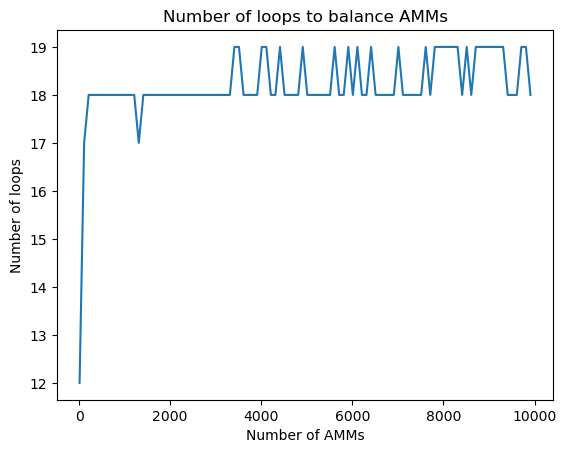

In [19]:
import matplotlib.pyplot as plt
plt.plot(amm_ns, steps)
plt.title("Number of loops to balance AMMs")
plt.xlabel("Number of AMMs")
plt.ylabel("Number of loops")

#### Old implementation before using the formula for delta D:

In [30]:
import random
class AMM:
    def __init__(self):
        self.R = [random.randint(10,1000), random.randint(10,1000)]
        self.cp = round(float(self.R[0] * self.R[1]), 2)

    def __repr__(self):
        return f"AMM R={self.R}, cp={self.cp}"

    def price(self, output_pool, output_amount):
        input_pool = int(not output_pool)
        if self.R[output_pool] <= output_amount:
            return float('inf')
        price = output_amount * self.R[input_pool] / (self.R[output_pool] - output_amount)
        new_cp = (self.R[output_pool] - output_amount) * (self.R[input_pool] + price)
        assert round(new_cp, 2) == self.cp, f"constant product violated: expected: {self.cp}, actual: {new_cp}"
        return price
    
    def quote(self, input_pool, input_amount):
        output_pool = int(not input_pool)
        quote = input_amount * self.R[output_pool] / (self.R[input_pool] + input_amount)
        new_cp = (self.R[output_pool] - quote) * (self.R[input_pool] + input_amount)
        assert round(new_cp, 2) == self.cp, f"constant product violated: expected: {self.cp}, actual: {new_cp}"
        return quote
    
    def buy(self, purchased_pool, purchase_amount, trader=None):
        spent_pool = int(not purchased_pool)
        price = self.price(purchased_pool, purchase_amount)
        # print(f"original: {self}")
        self.R[spent_pool] += price
        self.R[purchased_pool] -= purchase_amount
        if trader:
            trader.B[spent_pool] -= price
            trader.B[purchased_pool] += purchase_amount

In [31]:
# just to make sure that the trader is making a profit for debugging
class Trader:
    def __init__(self):
        self.B = [0,0]
    
t = Trader()

In [32]:
amms = [AMM() for _ in range(1000)]
AMOUNT = 0.2
def arbitrage(amm1, amm2):
    # trade AMOUNT units of either currency as long as there is an arbitrage opportunity
    while True:
        # price of currency 1
        i0 = amm1.price(1, AMOUNT)
        # output of currency 0 from 1 of currency 1
        o0 = amm2.quote(1, AMOUNT)
        if o0 - i0 > 0:
            # spend (0, i0), get (1,1)
            amm1.buy(1, AMOUNT, t)
            # spend (1,1), get (0, o0). the price will be (1,1), which we just bought
            amm2.buy(0, o0, t)
            # print(f"profit: {o0-i0} of currency 0")
            continue
        # price of currency 1
        i1 = amm1.price(0, AMOUNT)
        # output of currency 0 from 1 of currency 1
        o1 = amm2.quote(0, AMOUNT)
        if o1 - i1 > 0:
            # spend (0, i0), get (1,1)
            amm1.buy(0, AMOUNT, t)
            # spend (1,1), get (0, o0). the price will be (1,1), which we just bought
            amm2.buy(1, o1, t)
            # print(f"profit: {o0-i0} of currency 0")
            continue
        break

In [33]:
def is_balanced(amms, epsilon):
    avg_ratio = sum(amm.R[0] / amm.R[1] for amm in amms) / len(amms)
    outside_bounds = sum(abs(amm.R[0] / amm.R[1] - avg_ratio) > epsilon for amm in amms)
    print(f"{outside_bounds} outside bounds")
    return outside_bounds == 0
is_balanced(amms, 1)

759 outside bounds


False

In [34]:
j = 0
while not is_balanced(amms, 1e-2):
    random.shuffle(amms)
    print(j)
    j += 1
    for amm1, amm2 in zip(amms[:-1], amms[1:]):
        arbitrage(amm1, amm2)

998 outside bounds
0
987 outside bounds
1
983 outside bounds
2
945 outside bounds
3
904 outside bounds
4
842 outside bounds
5
745 outside bounds
6
581 outside bounds
7
368 outside bounds
8
124 outside bounds
9
23 outside bounds
10
4 outside bounds
11
0 outside bounds
